# Kalman Filtering

v1.2 (2023 Spring): Reina Wang, Thomas Courtade

v1.1 (2022 Spring): Akshit Dewan, Clark Wang, Catherine Huang

v1.0 (2020 Spring): Aditya Sengupta, William Gan, Kannan Ramchandran

In [3]:
from kalman_utils import *
%matplotlib inline

## Introduction

In this lab, we'll cover applications of the Kalman filter, which is the optimal linear algorithm for sensor fusion: combining information from sensors and from an underlying physics model of a system to get the best possible state estimate.

At its core, the Kalman filter is optimal because it incorporates covariance matrices. As an example, suppose I’m trying to estimate a random variable $X$, and my current estimate is $\hat{X} = 10$. I have another random variable $Y = X + W$, where $W$ is some noise, and upon observing $Y$, I see that it’s 15. How should I update $\hat{X}$ then? Should it be 12.5? Well, if $X$ has very low variance, then maybe it should be closer to 10. If $W$ has very large variance, then an observation of 15 might not be too crazy, so it should be closer to 10 as well. In the opposite situations, we could see why it might be closer to 15. Based on the covariance matrices of $X$ and $W$, we can figure out what optimizes minimum mean square error.

In more detail, say our current estimate of a random variable $X$ is $\hat{X}$ and we have Gaussian covariance $\Sigma_1$ around it. Suppose we then observe $Y \sim \mathcal{N}(X, \Sigma_2)$, and want to update our estimate; this comes out to 

$$\hat{X}_{\text{updated}} = \hat{X} + \Sigma_1(\Sigma_1 + \Sigma_2)^{-1}(Y - \hat{X}) = \hat{X} + K(Y - \hat{X})$$
$$\Sigma_{\text{updated}} = \Sigma_1 - \Sigma_1(\Sigma_1 + \Sigma_2)^{-1}\Sigma_1 = \Sigma_1 - K \Sigma_1$$

These are essentially taking the first Gaussian, and adjusting it so that it ends up somewhere in between the first and the second one. We can pull out a common "adjustment factor", $K = \Sigma_1(\Sigma_1 + \Sigma_2)^{-1}$, and call it the Kalman gain. The estimate increases with a factor proportional to the Kalman gain, and the covariance reduces by a factor proportional to the Kalman gain.

The rest of the Kalman filter math just deals with how to set up these two Gaussians, which will turn out to only require a few matrix multiplications!

## Dependencies

This lab needs the Python package `pyautogui`, which provides functions to control your computer's mouse and keyboard. If you don't already have it, you can pip install it:

In [4]:
%pip install pyautogui -q

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pyautogui

## Implementation and Kinematics

Let's implement a generic Kalman filter, and then apply it to some simple dynamic models! The following equations, replicated from the [note](https://inst.eecs.berkeley.edu/~ee126/sp22/notes/kalman.pdf#page=5), capture the model we use for the Kalman Filter:

$$\begin{eqnarray*}
X_n = AX_{n-1} + V_{n-1} \text{(eq 6)}\\
Y_n = CX_n + W_n \text{(eq 7)}\\
\end{eqnarray*}$$

You will be implementing the predict and update steps of the filter using the equations below:

$$\begin{eqnarray*}
\hat{X}_{n + 1 \mid n} = A \hat{X}_{n \mid n} & \text{(eq 6)}\\
\Sigma_{n + 1 \mid n} = A\Sigma_{n \mid n} A^\intercal + \Sigma_V & \text{(eq 11)}\\
\end{eqnarray*}$$

Equations 6 and 11 represent a one timestep update to the filter, without yet taking into account the new observation. These will be used the predict function.

$$\begin{eqnarray*}
K_n = \Sigma_{n + 1 \mid n} C^\intercal (C \Sigma_{n + 1 \mid n} C^\intercal + \Sigma_W)^{-1} & \text{(eq 10)}\\
\Sigma_{n|n} = (I - K_nC) \Sigma_{n|n-1} &\text{(eq 12)}\\
\end{eqnarray*}$$

Equation 10 calculates the Kalman gain, which represents how much to weight the next observation. Equation 12 updates the variance of the estimate. 

$$\begin{eqnarray*}
\tilde{Y_n} = Y_n - C\hat{X}_{n\mid n-1}&\text{(eq 9)}\\
\hat{X}_{n + 1 \mid n + 1} = \hat{X}_{n + 1 \mid n} + K_n \tilde{Y_n} & \text{(eq 8)}
\end{eqnarray*}$$

Equation 9 calculates the innovation, which is the orthogonalized measurement and Equation 8 incorporates this measurement into the state estimate.



### Question 1: Implementation

**Fill in the code to complete the ```predict``` and ```update``` functions below.** It may be helpful to refer to the vector case Kalman filter equations from the notes. A few clarifications:

- `self.state` is our current estimate $\hat{X}_n$.
- `self.P` is the covariance around the current estimate $\Sigma_{n \mid n}$.
- `self.Q` is $\Sigma_V$, `self.R` is $\Sigma_W$.
- In `predict`, change `self.state` to $\hat{X}_{n + 1 \mid n}$ and `self.P` to $\Sigma_{n+1 \mid n}$.
- In `update`, calculate `self.K` (if not in steady state), and change `self.P` to $\Sigma_{n+1 \mid n+1}$. Also update `self.state` to $\hat{X}_{n+1}$.

In [10]:
class KFilter(AbstractKFilter):
    def __init__(self, A, Q, C, R, state=None):
        self.A = A
        self.Q = Q
        self.C = C
        self.R = R
        self.s = A.shape[0]
        self.m = C.shape[0]
        if state is None:
            self.state = np.zeros(self.s)
        else:
            self.state = state
        self.prev_P = np.zeros((self.s, self.s))
        self.P = np.zeros((self.s, self.s))
        self.steady_state = False
    
    def predict(self):
        self.prev_P = copy.deepcopy(self.P)
        self.state = self.A @ self.state
        self.P = self.A @ self.P @ self.A.T + self.Q
        
    def update(self, measurement):
        if not self.steady_state:
            self.K = self.P @ self.C.T @ np.linalg.inv(self.C @ self.P @ self.C.T + self.R)
            self.P -= self.K @ (self.C @ self.P)
            if np.allclose(self.P, self.prev_P):
                self.steady_state = True
        innovation = measurement - self.C @ self.state
        self.state = self.state + self.K @ innovation

You can run the following test to verify your code.

In [11]:
def test_predict_and_update():
    A = np.array([[2, 1], [1, 2]])
    Q = np.array([[1, 0], [1, 1]])
    C = np.array([[1, 1]])
    R = np.array([[0.5]])
    state = np.array([3, 1])
    kf = KFilter(A, Q, C, R, state)
    kf.predict()
    assert np.allclose(kf.prev_P, np.array([[0, 0], [0, 0]]))
    assert np.allclose(kf.state, np.array([7, 5]))
    assert np.allclose(kf.P, np.array([[1, 0], [1, 1]]))
    kf.update(np.array([11]))
    assert np.allclose(kf.K, np.array([[2/7], [4/7]]))
    assert np.allclose(kf.P, np.array([[3/7, -2/7], [-1/7, 3/7]]))
    assert np.allclose(kf.state, np.array([47/7, 31/7]))
    print('All assertions passed')

In [12]:
test_predict_and_update()

All assertions passed


Now let's try some simple examples! To start with, let's consider some object that we start at rest, and that moves under some unknown random forces. We won't deal with modelling these forces yet; we'll just consider how they impact position and velocity over time.

In [14]:
dt = 1e-3
kinematics_data = pd.read_csv('kinematics.csv', header=0) 
times = np.array(kinematics_data['t'])
measurements_k = np.array(kinematics_data['measurements'])

Text(0.5, 1.0, 'Measurements')

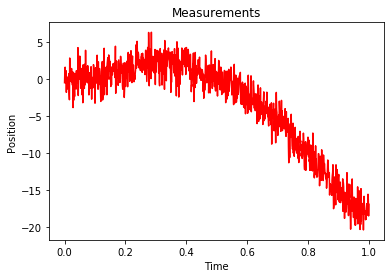

In [15]:
plt.plot(times, measurements_k, color='red')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Measurements')

We see that the measurements are too noisy for us to have an accurate idea of where the object is over time, but since we know the laws of motion it follows, we can improve that estimate a lot!

### Question 2: Linear Tracking
**Based on the following information, define the matrices A, Q, C, R below and run the filter to generate MMSE estimates of position and velocity.**
1. The object moves according to $p[n+1] = p[n] + v[n] \Delta t$, where $\Delta t = 10^{-3}$s (this was defined above in the variable `dt`).
2. The velocity is expected to stay constant, but may be perturbed by a force that causes a $\mathcal{N}(0, 1)$ change.
3. Measurements are only of position, and have a *standard deviation* of 1.5.

Once these have been defined, the line `states_2b = kinematics_forward.simulate(measurements_k)` will iterate through the measurements, compute the predictions and state updates, and return an array of size (state_size, num_timesteps) containing the state at each timestep. (The number of timesteps is set by the number of measurements; here it's 1000.)

As a reminder, we model the Kalman filter as follows:


Here's some ideas about what A, Q, C and R represent:
- $A$ represents the transition model. It takes in a previous state (position, velocity pair) and moves it forward by one timestep.
- $Q$ represents $Sigma_V$, which is the covariance matrix of the noise $V$ in the state update. For example, $Q_{ii}$ represents the variance of the noise added to the i-th value in the state.
- $C$ allows us to get from a state $X$ to a measurement. For example, you may want to extract just the position from the state vector.
- $R$ is the covariance matrix of the noise $W$ in the measurement.

Lastly, note that all the matrices must be 2d numpy arrays as that is what the `KFilter` class expects.

In [16]:
A = np.array([[1, dt], [0, 1]])
Q = np.array([[0, 0], [0, 1]])
C = np.array([[1, 0]])
R = np.array([[2.25]])
kinematics_forward = KFilter(A, Q, C, R)
states_2b = kinematics_forward.simulate(measurements_k)

In [17]:
states_2b

array([[ 0.00000000e+00,  4.30704527e-07,  4.46083957e-06, ...,
        -1.84616018e+01, -1.84919240e+01, -1.84647431e+01],
       [ 0.00000000e+00,  4.30704527e-04,  2.59036297e-03, ...,
        -3.16147273e+01, -3.15911282e+01, -3.05180483e+01]])

In [18]:
# BEGIN YOUR SOLUTION
position_estimates, velocity_estimates = states_2b
# END YOUR SOLUTION

Percent error of measurements from truth: 5.52
Percent error of KFilter predictions from truth: 1.49


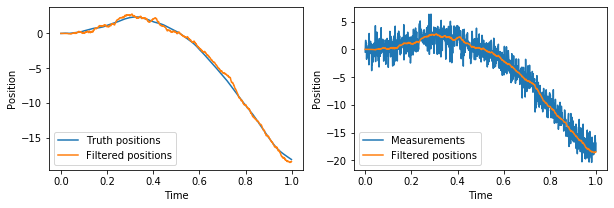

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].plot(times, kinematics_data["truth_p"], label='Truth positions')
axs[0].plot(times, position_estimates, label='Filtered positions')
axs[0].legend()
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Position')
axs[1].plot(times, np.array(measurements_k), label='Measurements')
axs[1].plot(times, position_estimates, label='Filtered positions')
axs[1].legend()
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Position')
pos_error_measurements = percent_rms_err(np.array(kinematics_data['truth_p']), measurements_k)
pos_error_predictions = percent_rms_err(np.array(kinematics_data['truth_p']), position_estimates)
print(f'Percent error of measurements from truth: {pos_error_measurements:.2f}')
print(f'Percent error of KFilter predictions from truth: {pos_error_predictions:.2f}')

Another thing we can do is look at velocity! If you try to numerically differentiate velocity (take pointwise differences and divide them by the time interval), it's really sensitive to little perturbations and won't have much coherence over time. If you run the cell below, you'll see that the measurement of velocity (differences in position between steps, divided by the time-step) is off by orders of magnitude, and also has high variance: it's essentially white noise.

Percent error of differentiated positions from truth: 2906.18


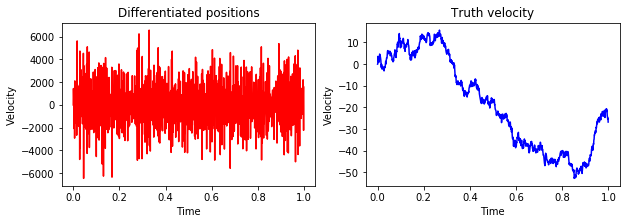

In [21]:
differentiated_positions = np.insert(np.diff(measurements_k), 0, 0) / dt
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].plot(times, differentiated_positions, color='red')
axs[0].set_title('Differentiated positions')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Velocity')
axs[1].plot(times, kinematics_data['truth_v'], color='blue')
axs[1].set_title('Truth velocity')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Velocity')
vel_error_diff = percent_rms_err(differentiated_positions, kinematics_data['truth_v'])
print(f'Percent error of differentiated positions from truth: {vel_error_diff:.2f}')

To contrast that, let's plot the Kalman filtered velocity, which gives us the MMSE of velocity over time!

Percent error of KFilter predictions from truth: 11.70


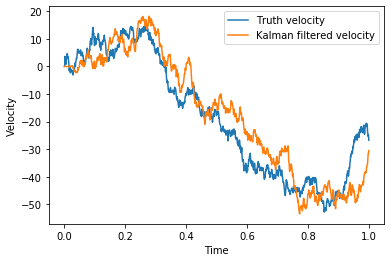

In [22]:
plt.plot(times, kinematics_data['truth_v'], label='Truth velocity')
plt.plot(times, velocity_estimates, label='Kalman filtered velocity')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Velocity")
vel_error_predictions = percent_rms_err(states_2b[1], kinematics_data['truth_v'])
print(f'Percent error of KFilter predictions from truth: {vel_error_predictions:.2f}')

We still don't have any direct measurements of velocity, but we've been able to leverage what we know about the state and measurement variances to get a much better estimate!

### Question 3: Kalman Smoothing

In real-time control situations, the above is the best estimate we're able to get. However, when we're postprocessing, we can also run the filter *backwards* and average the two results to smooth out the estimates.

**(i)** Modify any of the input matrices as needed to create a filter that runs backwards in time through all the measurements, and produce state estimates from that. Then, average the two runs and compare the RMS errors in position and velocity to those from the forward run.

In [23]:
A_back = np.array([[1, -dt], [0, 1]])
Q_back = Q
C_back = C
R_back = R

In [24]:
R_back

array([[2.25]])

In [25]:
kinematics_backward = KFilter(A_back, Q_back, C_back, R_back, states_2b.T[-1])
reversed_measurements = kinematics_data['measurements'][::-1]
states_2c = np.flip(kinematics_backward.simulate(reversed_measurements), axis=1)
smooth_states = (states_2b + states_2c) / 2
pos_error_smooth = percent_rms_err(smooth_states[0], kinematics_data["truth_p"])
vel_error_smooth = percent_rms_err(smooth_states[1], kinematics_data["truth_v"])
print(f'Old Position Error: {pos_error_predictions:.2f} New Error: {pos_error_smooth:.2f}')
print(f'Old Velocity Error: {vel_error_predictions:.2f} New Error: {vel_error_smooth:.2f}')

Old Position Error: 1.49 New Error: 1.24
Old Velocity Error: 11.70 New Error: 7.84


**(ii)** Look at the covariance matrices for the forward and backward directions. What differences do you see between them? Why do you think that is?

In [26]:
kinematics_forward.P

array([[166.42237761, 314.63740659],
       [314.63740659, 793.76798779]])

In [27]:
kinematics_backward.P

array([[ 166.42237761, -314.63740659],
       [-314.63740659,  793.76798779]])

Position and velocity are exactly oppositely correlated in both cases. This shouldn't be surprising, as in the backward case we were effectively using the negative of velocity at each timestep.

### Question 4: Mouse Movement

We can easily extend our one-dimensional tracker to two dimensions; by doing this, we've developed a filter that'll accurately return states of, for example, a robot moving around on a flat plane. In this question, we'll explore how to tune and interpret such a model, using the movement of your mouse across your computer screen as measurements! 

In the cell below, define your own A, Q, C, R matrices by making a model that you think accurately represents moving your mouse across the screen (with an added measurement noise term, to more closely model a real-life system). Then run the cell, move your mouse around the screen, and see how well your filter does! Play around with the $Q$ and $R$ values, or with the way you move your mouse, and note how performance changes. Try and get the RMS error below the baseline (by more than a pixel). 

General comments to help you do this:
- $x$ and $y$ motion can be modeled independently of one another, both similarly to how you did it in 2b (you may also make a more complicated model here and see how it affects the error).
- $Q$ and $R$ can be diagonal matrices in almost every use case, and the diagonal values can be tuned based on what works. How much do you think is reasonable for process error in this case? Measurement error?
- It's also okay to change $dt$, though that shouldn't be necessary.
- The most variance is likely in the position movement

Once you've done this, briefly answer the following questions!

Start moving!

Baseline          25.455844122715714 px
Tracker RMS Error 20.471458320478746 px


Text(0.5, 1.0, 'Residuals')

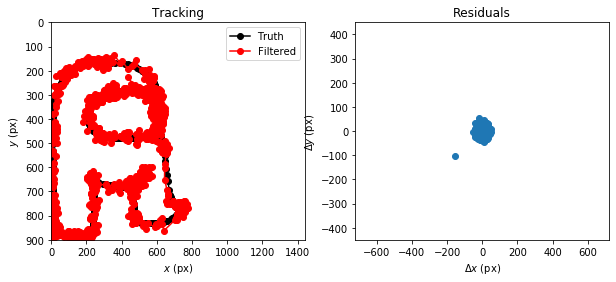

In [36]:
num_iters = 1500
measurement_error_sd = 20 * min(pyautogui.size()) / 1000
dt = 1e-2
A = np.array([[1, dt, dt**2/2, 0, 0, 0], 
              [0, 1, dt, 0, 0, 0], 
              [0, 0, 1, 0, 0, 0], 
              [0, 0, 0, 1, dt, dt**2/2], 
              [0, 0, 0, 0, 1, dt], 
              [0, 0, 0, 0, 0, 1]]
            ) # state is xp, xv, xa, yp, yv, ya

Q = np.diag(np.array([49, 1, 0, 49, 1, 0]))
C = np.array([[1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]])
R = np.diag(np.array([0.25 + measurement_error_sd, 0.25 + measurement_error_sd]))

tracker = KFilter(A, Q, C, R)
predictions = np.zeros((num_iters, 2))
updates = np.zeros((num_iters, 2))
truths = np.zeros((num_iters, 2))

print("Start moving!")
time.sleep(1)
iters = 0
total_error = 0

duration = dt
while iters < num_iters:
    t = time.time() * 1e6
    tracker.predict()
    prediction = tracker.measure()
    predictions[iters] = prediction
    m = np.array(pyautogui.position() + np.random.normal(0, measurement_error_sd, (2,)))
    truths[iters] = np.array(pyautogui.position())
    tracker.update(m)
    updated = tracker.measure()
    updates[iters] = updated
    if iters > 0: # skip the first iteration because the initial state is likely far off
        total_error += np.sum((updated - truths[iters]) ** 2)
    iters += 1
    duration = (time.time() * 1e6 - t) / 1e6
    time.sleep(max(0, dt - duration))

print("\nBaseline         ", np.sqrt(2) * measurement_error_sd, "px")
print("Tracker RMS Error", np.sqrt(total_error / iters), "px")
screensize = pyautogui.size()
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].set_xlim((0, screensize[0]))
axs[0].set_ylim((screensize[1], 0))
axs[0].set_xlabel(r"$x$ (px)")
axs[0].set_ylabel(r"$y$ (px)")
axs[0].plot(truths[:,0], truths[:,1], 'ko-', label='Truth')
axs[0].plot(updates[:,0], updates[:,1], 'ro-', label='Filtered')
axs[0].set_title("Tracking")
axs[0].legend()
axs[1].set_xlim((-screensize[0]/2, screensize[0]/2))
axs[1].set_ylim((-screensize[1]/2, screensize[1]/2))
axs[1].set_xlabel(r"$\Delta x$ (px)")
axs[1].set_ylabel(r"$\Delta y$ (px)")
axs[1].scatter(*(updates.T - truths.T))
axs[1].set_title("Residuals")

In [37]:
tracker.P

array([[ 14.16444299,   1.96619099,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  1.96619099, 681.73889852,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,  14.16444299,
          1.96619099,   0.        ],
       [  0.        ,   0.        ,   0.        ,   1.96619099,
        681.73889852,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ]])

**(i) Briefly describe how you defined $A$, $Q$, $C$, and $R$, and report the tracker RMS error.**

$A$ and $C$ come from the linear model from before plus an acceleration term; $R$ comes out of the measurement_error_sd term (plus a discretization error of 0.5 that isn't strictly necessary); $Q$ comes out of empirical tuning that can be done fairly easily by thinking about what each variable represents (what's the farthest I can move my mouse in a particular direction in 0.01 seconds?)

Tracker RMS error, around 20-21 pixels on a baseline of 25 pixels, although the noise level and therefore this error varies based on your screen size. Additionally, this could go up to barely any correction if the underlying motion isn't smooth enough.

**(ii) While varying the model parameters, you may have seen the tracker doing about the same as the baseline (if you didn't, try setting $Q$ really low or really high.) What might cause this?**

This is usually an indication that the physics predictions aren't useful - either the filter is just outputting the noisy measurements, or it's making guesses based on physics predictions that aren't accurate and so those effects average out and don't do anything to cancel the measurement error. If $Q$ is set low, the filter "thinks" there's a high degree of certainty around the predictions, whereas in reality moving your mouse around has a lot of sharp turns and generally isn't very linear. Sometimes the physics predictions help the filter, sometimes they harm it.

Setting $Q$ high can have this effect too: the filter doesn't trust the physics predictions enough, so it just reads and spits out the measurements without doing much correction. But by choosing $Q$ somewhat accurately, we can balance out these two effects and actually cause the error to reduce, like we've done here. Modeling uncertainties properly means your models can be a lot simpler!

### Conclusion

In this lab, we've mostly focused on one aspect of Kalman filtering, namely postprocessing noisy measurements. This was so that we could illustrate the filter without the complexities of real-time control, which is the main topic of several other classes. However, the filter has many other applications and extensions. Some possible fun reads if you really love Kalman filtering now:

1. [Kalman filtering for improving the precision of GPS](https://conference.scipy.org/proceedings/scipy2018/pdfs/mark_wickert_247.pdf)
2. [A Kalman filter that learns its own transition model online](https://www.sciencedirect.com/science/article/abs/pii/S0262885612001783)
3. [The Extended Kalman filter (EKF), which linearizes nonlinear systems so that we can still use the Kalman filter on them](https://www.cse.sc.edu/~terejanu/files/tutorialEKF.pdf)
4. [The Ensemble Kalman filter (EnKF), which uses Monte Carlo methods to avoid doing derivatives in EKF problems](ftp://ftp.esat.kuleuven.be/pub/stadius/gillijns/reports/TR-05-58.pdf)
5. [A Kalman filter in the frequency domain](https://arxiv.org/pdf/1808.08442.pdf)
6. [A parametrized Kalman filter for
fast track fitting at LHCb](http://cds.cern.ch/record/2759269/files/2101.12040.pdf)

**Sources/References**

1. https://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/
2. https://matplotlib.org/3.1.1/gallery/statistics/confidence_ellipse.html#sphx-glr-gallery-statistics-confidence-ellipse-py
3. https://stackoverflow.com/questions/3129322/how-do-i-get-monitor-resolution-in-python/14124257
4. https://www.cs.utexas.edu/~teammco/misc/kalman_filter/